(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Load project package
@load_pkg Antibiotic

import Revise
# Import project package
import Antibiotic
# import tools to benchmark
import BenchmarkTools

# Import package to save outputs
import BSON

# Import statistical functions
import Random
import StatsBase
import Distributions

# Import basic math
import LinearAlgebra

# Import ML libraries
import Flux
import Zygote

# Import library to perform tensor operations
using TensorOperations: @tensor

# Import differential equations solver
import DifferentialEquations as DiffEq

# Load CairoMakie for plotting
using CairoMakie
import ColorSchemes
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
Antibiotic.viz.pboc_makie!()

# Differential geometry of latent space

`[explanation here]`

## Simple 3D example

To begin our exploration of the differential geometry ideas, let's work with a
simple example. Let us define a function of the form
$$
\underline{f}(x_1, x_2) =
\begin{bmatrix}
    x_{1}\\
    x_{2}\\
    \alpha \exp(- (x_{1}^2 + x_{2}^2))\\
\end{bmatrix}.
$$
This function will serve as our playground to have visual intuition about the
resulting latent space geometry.

In [2]:
# Define function
f(x₁, x₂) = 10 * exp(-(x₁^2 + x₂^2))

# Define complete vector function
f̲(x) = [x[1], x[2], f(x[1], x[2])]

f̲ (generic function with 1 method)

Let's generate a random set of numbers sampling points on the $x_1-x_2$ plane
that lie inside a circle of radius $r$. Furthermore, we will map these points to
3D space using our function $\underline{f}$.

In [3]:
Random.seed!(42)

# Define number of points to sample
n_sample = 1_000

# Defien radius
radius = 3

# Sample random radius
r_rand = radius .* sqrt.(Random.rand(n_sample))

# Sample random angles
θ_rand = 2π .* Random.rand(n_sample) 

# Convert form polar to cartesian coordinates
x_rand = Float32.(r_rand .* cos.(θ_rand))
y_rand = Float32.(r_rand .* sin.(θ_rand))
# Feed numbers to function
z_rand = f.(x_rand, y_rand)

# Compile data into matrix
data = Matrix(hcat(x_rand, y_rand, z_rand)')

3×1000 Matrix{Float32}:
 -1.1037    -0.130005  1.22947   …  -1.85835     2.19925     0.88909
  0.586526  -1.69648   0.903149     -1.71827    -1.69536     0.856582
  2.0968     0.553015  0.975618      0.0165177   0.00447911  2.17792

Now, let's take a look at both the input and output space for our function. We
will color the points by the $z$-value given by our function $\underline{f}$.

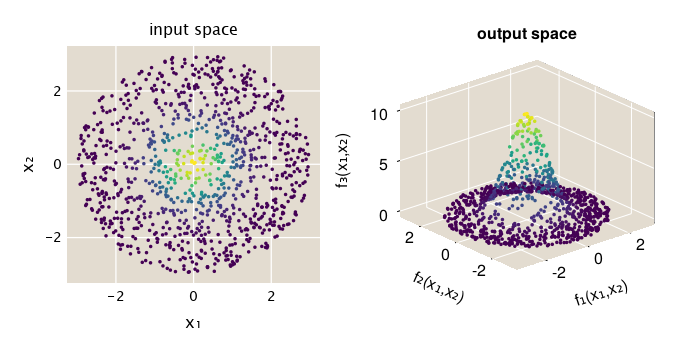

In [4]:
# Initialize figure
fig = Figure(resolution=(2 * 350, 350))

# Add GridLayout
gl = GridLayout(fig[1, 1])

# Add axis for input space
ax_input = Axis(
    gl[1, 1],
    xlabel="x₁",
    ylabel="x₂",
    title="input space"
)

# Plot input space
scatter!(
    ax_input,
    x_rand,
    y_rand,
    markersize=5,
    color=z_rand,
    colormpa=:viridis
)

# Add axis for output space
ax_output = Axis3(
    gl[1, 2],
    xlabel="f₁(x₁,x₂)",
    ylabel="f₂(x₁,x₂)",
    zlabel="f₃(x₁,x₂)",
    title="output space",
    xypanelcolor="#E3DCD0",
    xzpanelcolor="#E3DCD0",
    yzpanelcolor="#E3DCD0",
    xgridcolor=:white,
    ygridcolor=:white,
    zgridcolor=:white,
)

# Plot output space
scatter!(
    ax_output,
    data[1, :],
    data[2, :],
    data[3, :],
    markersize=5,
    color=data[3, :],
    colormap=:viridis,
)

# Separate axis
colgap!(gl, 50)

fig

This looks like a very useful function on which to test the
differential-geometry ideas and gain visual intuition.

### Computing the Riemmanian metric

`[explanation here]`

Let's define a function to compute this Riemmanian metric using `Zygote.jl` for
the numerical differentiation.

In [5]:
@doc raw"""
    riemmanian_metric(manifold, val)

Function to compute the metric `M̲̲ = J̲̲ᵀJ̲̲` of a Riemmanian manifold via
numerical differentiation with `Zygote.jl`.

# Arguments
- `manifold::Function`: Function defining the manifold.
- `val::Vector{<:AbstractFloat}`: Value where to evaluate the metric.

# Returns
- `M̲̲::Matrix{<:AbstractFloat}`: Matrix evaluating the Riemmanian manifold
  metric.
"""
function riemmanian_metric(
    manifold::Function, val::AbstractVector{T}
)::Array{T} where T <: AbstractFloat
    # Compute Jacobian
    jac = first(Zygote.jacobian(manifold, val))
    # Initialize
    return jac' * jac
end # function


riemmanian_metric

Let's check how long it takes to estimate this Riemmanian metric numerically.

In [6]:
BenchmarkTools.@benchmark riemmanian_metric(f̲, [1.0, 1.0])

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  20.333 μs … 101.166 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     20.959 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   21.218 μs ±   1.441 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

      ▁▆█▆▅▂                                                    
  ▁▂▄▅███████▆▄▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  20.3 μs         Histogram: frequency by time         25.2 μs <

 Memory estimate: 6.78 KiB, allocs estimate: 203.

Let's test this function for a range of values on the latent space, computing
the square root of the determinant of the metric at each point as a measurement
of the local deformation on the manifold.

In [7]:
# Define numebr of points in range
n_range = 100

# Set range of values where to evaluate jacobian 
z1 = z2 = LinRange{Float32}(-radius * 1.1, radius * 1.1, n_range)

manifold_metric = sqrt.(
    LinearAlgebra.det.(
        [riemmanian_metric(f̲, collect(x)) for x in Iterators.product(z1, z2)]
    )
)

100×100 Matrix{Float32}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 ⋮                        ⋮              ⋱            ⋮                   
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

Now, let's plot this quantity bot on the input and output space to gain
intuition to what it represents.

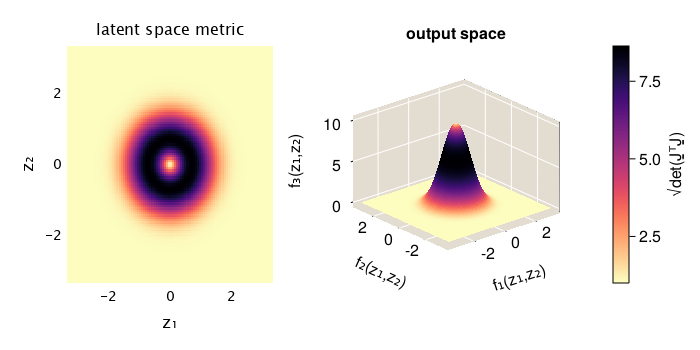

In [8]:
# Initialize figure
fig = Figure(resolution=(2 * 350, 350))

# Add GridLayout
gl = GridLayout(fig[1, 1])

# Add axis for latent space
ax1 = Axis(
    gl[1, 1],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space metric",
)

# Plot metric as a heatmap
hm = heatmap!(
    ax1, z1, z2, manifold_metric, colormap=Reverse(:magma),
)

# Add axis for latent space
ax2 = Axis3(
    gl[1, 2],
    xlabel="f₁(z₁,z₂)",
    ylabel="f₂(z₁,z₂)",
    zlabel="f₃(z₁,z₂)",
    title="output space",
    xypanelcolor="#E3DCD0",
    xzpanelcolor="#E3DCD0",
    yzpanelcolor="#E3DCD0",
    xgridcolor=:white,
    ygridcolor=:white,
    zgridcolor=:white,
)

# Evaluate function on grid
f_output = hcat(vec([f̲(collect(x)) for x in Iterators.product(z1, z2)])...)

# Plot surface
surface!(
    ax2, 
    eachrow(f_output)..., 
    colormap=Reverse(:magma), 
    color=vec(manifold_metric),
    colorrange=(minimum(manifold_metric), maximum(manifold_metric)),
    shading=false,
)

# Add colorbar
Colorbar(fig[:, end+1], hm, label="√det(J̲̲ᵀJ̲̲)") 

# Separate axis
colgap!(gl, 50)

fig

We can see that indeed the determinant of the metric captures the local
deformation of the manifold.

### Computing geodesics

`[explanation here]`

Defining the geodesic differential equations requires computing the so-called
[Christoffel symbols](https://en.wikipedia.org/wiki/Christoffel_symbols). For
this, we must evaluate the derivative of the Riemmanian metric as a function of
the coordinates on the latent space. Let's define such function to compute the
derivative numerically, again using `Zygote.jl` for automatic differentiation.

In [9]:
@doc raw"""
    ∂M̲̲∂γ̲(manifold, val, out_dim)

Function to compute the derivative of the Riemmanian metric `M̲̲` as a function
of the coordinates in the input space using `Zygote.jl`.

# Arguments
- `manifold::Function`: Function defining the manifold.
- `val::Vector{<:AbstractFloat}`: Value where to evaluate the metric.
- `out_dim::Int`: Dimensionality of the output space. This is required because
  `Zygote.jl` cannot compute the required derivatives automatically, but we have
  to "manually" iterate over the variables in the output space, one at the time.

# Returns
- `∂M̲̲::Array{<:AbstractFloat}`: Rank-3 tensor evaluating the derivative of the
  Riemmanian manifold metric.
"""
function ∂M̲̲∂γ̲(
    manifold::Function, val::Vector{T}, out_dim::Int
)::Array{T} where T <: AbstractFloat
    # Compute the manifold Jacobian. This should be a D×d matrix where D is the
    # dimension of the output space, and d is the dimension of the manifold.
    # Note that we use first() to extract the object we care about from the
    # Zygote output.
    J̲̲ = first(Zygote.jacobian(manifold, val))

    # Compute Hessian tensor, i.e., the tensor with the manifold second
    # derivatives. This should be a D×d×d third-order tensor, where D is the
    # dimension of the output space, and d is the dimension of the manifold.
    # Note that we have to manually evaluate the hessian on each dimension of
    # the output.
    H̲̲ = permutedims(
        cat(
            [Zygote.hessian(v -> manifold(v)[D], val) for D=1:out_dim]..., 
            dims=3
        ),
        (3, 1, 2)
    )

    # Compute the derivative of the Riemmanian metric. This should be a d×d×d
    # third-order tensor.
    return @tensor ∂M̲̲[i, j, k] := H̲̲[l, i, k] * J̲̲[l, j] + 
                                                   H̲̲[l, k, j] * J̲̲[l, i]
end # function

∂M̲̲∂γ̲

With this function in hand, we can compute the Christoffel symbols. Let's define
a function that returns this quantity.

In [10]:
@doc raw"""
    christoffel_symbols(manifold, val, out_dim)

Function to compute the Christoffel symbols from the Riemmanian metric `M̲̲` as
a function of the coordinates in the input space using `Zygote.jl`.

# Arguments
- `manifold::Function`: Function defining the manifold.
- `val::Vector{<:AbstractFloat}`: Value where to evaluate the metric.
- `out_dim::Int`: Dimensionality of the output space. This is required because
  `Zygote.jl` cannot compute the required derivatives automatically, but we have
  to "manually" iterate over the variables in the output space, one at the time.

# Returns
- `Γᵏᵢⱼ::Array{<:AbstractFloat}`: Rank-3 tensor evaluating the Christoffel
  symbols given a Riemmanian manifold metric.
"""
function christoffel_symbols(
    manifold::Function, val::Vector{T}, out_dim::Int
)::Array{T} where T <: AbstractFloat
    # Evaluate metric inverse
    M̲̲⁻¹ = LinearAlgebra.inv(riemmanian_metric(manifold, val))

    # Evaluate metric derivative
    ∂M̲̲ = ∂M̲̲∂γ̲(manifold, val, out_dim)

    # Compute Christoffel Symbols
    return @tensor Γᵏᵢⱼ[i, j, k] := (1 / 2) * M̲̲⁻¹[k, h] * 
    (∂M̲̲[i, h, j] + ∂M̲̲[j, h, i] - ∂M̲̲[i, j, h]) 
end # function

christoffel_symbols

Finally, with these functions in hand, we can define the 2nd order ODE system
defining the geodesic equations. This will be used by `DifferentialEquations.jl`
to numerically find geodesics.

In [11]:
@doc raw"""
    geodesic_system!(du, u, param, t)

Funtion thefining the right-hand side of the system of geodesic ODEs. The
function is evaluated in place⸺making `du` the first input⸺to accelerate the
integration. To define the 2nd order system of differential equtions we define a
system of coupled 1st order ODEs.

# Arguments
- `du::Array{<:AbstractFloat}`: derivatives of state variables. The first `end ÷
  2` entries define the velocity in latent space where the curve γ is being
  evaluated, i.e., dγ/dt. The second half defines the acceleration of the curve,
  i.e., d²γ/dt².
- `u::Array{<:AbstractFloat}`: State variables. The first `end ÷ 2` entries
  define the coordinates in latent space where the curve γ is being evaluated,
  i.e., γ. The second half defines the velocity of the curve, i.e., dγ/dt.
- `param::Dictionary`: Parameters required for the geodesic differential
  equation system and the boundary value integration. The list of required
  parameters are:
  - `in_dim::Int`: Dimensionality of input space.
  - `out_dim::Int`: Dimensionality of output space.
  - `manifold::Function`: Function definining the manifold.
  - `γ_init::Vector{<:AbstractFloat}`: Initial position in latent space.
  - `γ_end::Vector{<:AbstractFloat}`: Final position in latent space.
- `t::AbstractFloat`: Time where to evaluate the righ-hand side.
"""
function geodesic_system!(du, u, param, t)
    # Extract dimensions d and D
    in_dim, out_dim = param[:in_dim], param[:out_dim]
    # Extract manifold function
    manifold = param[:manifold]

    # Set curve coordinates 
    γ = u[1:in_dim] 
    # Set curve velocities
    dγ = u[in_dim+1:end]

    # Compute Christoffel symbols
    Γᵏᵢⱼ = christoffel_symbols(manifold, γ, out_dim)

    # Define the geodesic system of 2nd order ODEs
    @tensor d²γ[k] := - Γᵏᵢⱼ[i, j, k] * dγ[i] * dγ[j]

    # Update derivative values
    du .= [dγ; d²γ]
end # function

geodesic_system!

The integration between a defined initial and final point requires a function
that computes the residuals between the current value of the function and the
boundary conditions. This will be used to set the integration such that it
matches our desired boundary conditions.

In [12]:
@doc raw"""
    boundary_condition!(residual, u, param, t)

Function that evaluates the residuals between the current position and the
desired boundary conditions.

# Arguments
- `residual::Vector{<:AbstractFloat}`: Array containing the residuals between
  the desired boundary conditions and the current state.
- `param::Dictionary`: Parameters required for the geodesic differential
  equation system and the boundary value integration. The list of required
  parameters are:
  - `in_dim::Int`: Dimensionality of input space.
  - `out_dim::Int`: Dimensionality of output space.
  - `manifold::Function`: Function definining the manifold.
  - `γ_init::Vector{<:AbstractFloat}`: Initial position in latent space.
  - `γ_end::Vector{<:AbstractFloat}`: Final position in latent space.
- `t::AbstractFloat`: Time where to evaluate the righ-hand side.
"""
function boundary_condition!(residual, u, param, t)
    # Extract parameters
    in_dim = param[:in_dim]

    # Compute residual for initial position
    @. residual[1:in_dim] = u[1][1:in_dim] - param[:γ_init]
    
    # Compute residual for final position
    @. residual[in_dim+1:end] = u[end][1:in_dim] - param[:γ_end]
end # function

boundary_condition!

Finally, we have everything in place to test this integration! Let us define the
required parameters as well as the `DifferentialEquations.jl` problem. For our
particular integration, we will use the `BVProblem` function to define our
boundary value problem.

In [13]:
# Define parameters
param = Dict(
    :in_dim => 2,
    :out_dim => 3,
    :manifold => f̲,
    :γ_init => [2.0, -2.0],
    :γ_end => [-2.0, 1.0]
)

# Define time span
tspan = (0.0, 1.0)

# Define boundary value problem
bvp = DiffEq.TwoPointBVProblem(
# bvp = DiffEq.BVProblem(
    geodesic_system!, 
    boundary_condition!,
    [param[:γ_init]; param[:γ_end] .- param[:γ_init]],
    tspan,
    param
)

BVProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 1.0)
u0: 4-element Vector{Float64}:
  2.0
 -2.0
 -4.0
  3.0

Now, let's integrate the geodesic differential equations!

In [14]:
# Solve system
sol = DiffEq.solve(bvp, DiffEq.MIRK4(), dt=0.05)

retcode: Success
Interpolation: 1st order linear
t: 21-element Vector{Float64}:
 0.0
 0.05
 0.1
 0.15
 0.2
 0.25
 0.3
 0.35
 0.4
 0.45
 ⋮
 0.6
 0.65
 0.7
 0.75
 0.8
 0.85
 0.9
 0.95
 1.0
u: 21-element Vector{Vector{Float64}}:
 [2.0, -2.0, -5.800569357154359, 0.9359044587913057]
 [1.7100563760644363, -1.9532943758258048, -5.795509360665774, 0.9303822184716138]
 [1.4208239438469457, -1.9074361978675685, -5.7665973256761776, 0.8939086229428991]
 [1.1345111517390156, -1.8656580470858375, -5.673345644205727, 0.753799727505683]
 [0.8542419717617746, -1.8340557016049204, -5.5410272277160555, 0.5071444931759147]
 [0.5789787541729924, -1.8128894676464387, -5.487831470312543, 0.37911888799556764]
 [0.30394311939638563, -1.7913167855659893, -5.521664185403741, 0.5320797844936063]
 [0.026795332863733097, -1.7553087344870522, -5.557232956810137, 0.9455746424877789]
 [-0.2504835595074319, -1.6937059558175915, -5.5162905223489584, 1.5423881407337725]
 [-0.5227245337528127, -1.5993260091844088, -5.349

It seems to have worked! Let's take a look at the resulting geodesic both in the
input and output space.

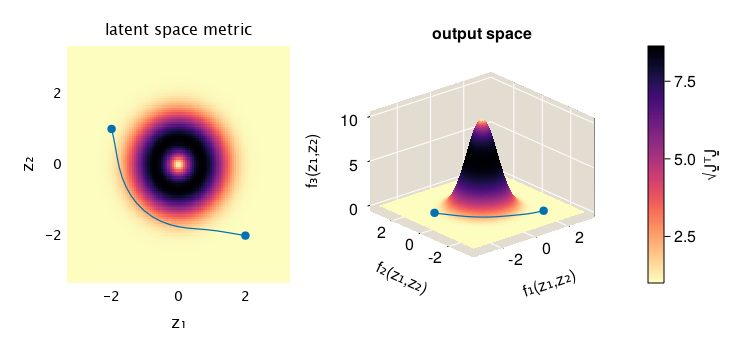

In [15]:
# Extract solutions into matrix
u = hcat(sol.u...)
# Split speed and coordinates
γ = u[1:param[:in_dim], :]
dγ = u[param[:in_dim]+1:end, :]

# Initialize figure
fig = Figure(resolution=(2.1 * 350, 350))

# Add GridLayout
gl = GridLayout(fig[1, 1])

# Add ax_inputis for latent space
ax_input = Axis(
    gl[1, 1],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space metric"
)

# Plot metric as a heatmap
hm = heatmap!(
    ax_input, z1, z2, manifold_metric, colormap=Reverse(:magma),
)

# Plot geodesic
lines!(ax_input, eachrow(γ)...)
# Add initial and final points
scatter!(ax_input, eachrow(γ[:, [1, end]])...)

# Plot velocities along trajectory
# arrows!(ax_input, γ[1, :], γ[2, :], dγ[1, :], dγ[2, :])

# Add axis for output space
ax_output = Axis3(
    gl[1, 2],
    xlabel="f₁(z₁,z₂)",
    ylabel="f₂(z₁,z₂)",
    zlabel="f₃(z₁,z₂)",
    title="output space",
    xypanelcolor="#E3DCD0",
    xzpanelcolor="#E3DCD0",
    yzpanelcolor="#E3DCD0",
    xgridcolor=:white,
    ygridcolor=:white,
    zgridcolor=:white,
)

# Evaluate manifold on pairs of latent variables
f_output = hcat(f̲.(vec(collect(Iterators.product(z1, z2))))...)

# Plot surface
surface!(
    ax_output, 
    eachrow(f_output)..., 
    colormap=Reverse(:magma), 
    color=vec(manifold_metric),
    colorrange=(minimum(manifold_metric), maximum(manifold_metric)),
    shading=false,
)

# Evaluate geodesic in output space
γ_output = hcat([f̲(x) for x in eachcol(γ)]...)

# Plot geodesic line
lines!(ax_output, [x for x in eachrow(γ_output)]...)

# Add initial and final point
scatter!(ax_output, eachrow(γ_output[:, [1, end]])...)

# Add colorbar
Colorbar(fig[:, end+1], hm, label="√J̲̲ᵀJ̲̲") 

# Separate axis
colgap!(gl, 50)

fig

#### Testing `Shooting` method (pending)

In [ ]:
function bc_shooting!(residual, u, param, t)
    # Extract parameters
    in_dim = param[:in_dim]

    # Compute residual for initial position
    @. residual[1:in_dim] = u(0.0)[1:in_dim] - param[:γ_init]
    # Compute residual for final position
    @. residual[in_dim+1:end] = u(1.0)[1:in_dim] - param[:γ_end]
end # function

In [ ]:
# Define parameters
param = Dict(
    :in_dim => 2,
    :out_dim => 3,
    :manifold => f̲,
    :γ_init => [-2.0, -2.0],
    :γ_end => [2.0, 2.0]
)

# Define time span
tspan = (0.0, 1.0)

# Define boundary value problem
bvp = DiffEq.BVProblem(
    geodesic_system!, 
    bc_shooting!,
    [param[:γ_init]; param[:γ_end] .- param[:γ_init]],
    tspan,
    param
)

# Solve system
sol = DiffEq.solve(
    bvp, DiffEq.Shooting(DiffEq.AutoTsit5(DiffEq.Rosenbrock23()))
)
# sol = DiffEq.solve(bvp, DiffEq.Shooting(DiffEq.Vern7()))

## Approximating geodesics with splines

> In practical terms, we compute these shortest paths by creating a uniform grid
> in latent space and computing, only once, the curve energy for the edges of
> this grid. After this expensive computation (which only needs to be performed
> once) we can use shortest-paths algorithms in graphs to create a suitable
> initialization of the geodesic. We fit a cubic spline to this initialization
> and then optimize its parameters further.

Let's define a function to compute the energy of a curve $\underline{\gamma}(t)$
on the manifold.

In [28]:
@doc raw"""
    curve_energy(γ, manifold)

Function to compute the (discretized) integral defining the energy of a curve γ
on a Riemmanina manifold. The energy is defined as

    E = ∫ dt ⟨γ̲̇(t), M̲̲ γ̲̇(t)⟩,

where γ̲̇(t) defines the velocity of the parametric curve, and M̲̲ is the
Riemmanian metric. For this function, we use finite differences from the curve
sample points `γ` to compute this integral.

# Arguments
- `γ::AbstractMatrix{<:AbstractFloat}`: `d×N` matrix where `d` is the dimension
  of the manifold on which the curve lies and `N` is the number of points along
  the curve. The larger this number, the more accurate the energy estimate will
  be.
- `manifold::Function`: Function defining the Riemmanian manifold on which the
  curve lies.
"""
function curve_energy(
    γ::AbstractMatrix{<:AbstractFloat}, manifold::Function
)
    # Evaluate finite differences
    δγ = diff(γ, dims=2)

    # Define Δt
    Δt = 1 / size(dγ, 2)

    # Evaluate and return energy
    return (1/2) * sum(
        [
            LinearAlgebra.dot(
                δγ[:, i], 
                riemmanian_metric(manifold, γ[:, i]), 
                δγ[:, i]
            ) * Δt 
            for i = 1:size(δγ, 2)
        ]
    ) 
end # function

curve_energy

Let's test this function on the resulting geodesic we obtained from the
integration of the differential equation.

In [29]:
curve_energy(γ, f̲)

0.041435244111791836

Let's benchmark this function.

In [30]:
BenchmarkTools.@benchmark curve_energy(γ, f̲)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  414.667 μs …  31.594 ms  ┊ GC (min … max): 0.00% … 98.17%
 Time  (median):     427.042 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   440.698 μs ± 536.569 μs  ┊ GC (mean ± σ):  2.10% ±  1.70%

    ▁▁▄█▇▆▄▂▁                                                    
  ▁▄██████████▇▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  415 μs           Histogram: frequency by time          506 μs <

 Memory estimate: 139.52 KiB, allocs estimate: 4108.

To optimize this curve energy, we need to compute the gradient of this energy
function. Let's define a function that does this.

In [31]:
function ∇curve_energy(
    γ::AbstractMatrix{T}, manifold::Function, out_dim::Int
) where T <: AbstractFloat

    # Initialize array where to save the metric evaluated at each point
    M̲̲ = zeros(T, repeat([size(γ, 1)], 2)..., size(γ, 2))

    # Initialize array where to save the derivative of the metric evaluated at
    # each point.
    ∂M̲̲ = zeros(T, repeat([size(γ, 1)], 3)..., size(γ, 2))

    # Loop through each γ value
    for k = 2:size(γ, 2)-1
        # Compute metric
        M̲̲[:, :, k] .= riemmanian_metric(manifold, γ[:, k])
        # Compute derivative of metric
        ∂M̲̲[:, :, :, k] .= ∂M̲̲∂γ̲(manifold, γ[:, k], out_dim)
    end # for

    # Initialize array to save gradient. Note: The gradient is obviously a
    # vector, but we will store it as an array to keep track of which point
    # along the curve each entry corresponds to
    ∇E = zeros(T, size(γ)...)
    
    # Loop through each of the entries
    for k = 1:size(γ, 2)-1
        # Extract relevant pieces
        _M̲̲ = @view M̲̲[:, :, k]
        _∂M̲̲ = @view ∂M̲̲[:, :, :, k]
        _γ = @view γ[:, k]
        _γ_ = @view γ[:, k+1]

        # Compute gradient
        @tensor ∇E[:, k][l] = 0.5 * (

            _∂M̲̲[i, j, l] * _γ[i] * _γ[j] +
            2 * _M̲̲[i, l] * _γ[i] +

            _∂M̲̲[i, j, l] * _γ_[i] * _γ_[j] +
            2 * _M̲̲[i, l] * _γ_[i] +

            -2 * (
                _∂M̲̲[i, j, l] * _γ_[i] * _γ[j] +
                _M̲̲[i, l] * _γ[i] +
                _M̲̲[i, l] * _γ_[i]
            )
        )
    end # for

    return ∇E
end # function

∇curve_energy (generic function with 1 method)

In [ ]:
BenchmarkTools.@benchmark ∇curve_energy(γ, f̲, 3)

In [32]:
function curve_gradient_descent!(
    γ::AbstractMatrix{<:AbstractFloat}, 
    manifold::Function, 
    out_dim::Int,
    n_steps=100;
    step_size::AbstractFloat=1E-3
)
    # Loop through steps
    for step = 1:n_steps
        # Update curve
        γ .= γ .- step_size .* ∇curve_energy(γ, manifold, out_dim)
    end # for
end # function

curve_gradient_descent! (generic function with 2 methods)

In [33]:
function curve_init(
    γ_init::Vector{T}, γ_end::Vector{T}, n_points::Int
) where T <: AbstractFloat
    # Initialize array where to return curve
    γ = Matrix{T}(undef, length(γ_init), n_points)
    # Set initial and final points
    γ[:, 1] = γ_init
    γ[:, end] = γ_end

    # Loop through dimensions
    for d = 1:length(γ_init)
        # Interpolate between points
        γ[d, 2:end-1] = LinRange(γ_init[d], γ_end[d], n_points-2)
    end # for

    return γ
end # function

curve_init (generic function with 1 method)

In [34]:
# Define points to connect
# γ_init = [2.0, -2.0]
γ_init = [1.0, -1.5]
γ_end = [-2.0, 0.0]

# Define number of points
n_points = 25

# Initialize curve
γ₀ = curve_init(γ_init, γ_end, n_points)
# Copy curve to optimize
γ_opt = deepcopy(γ₀)

# Optimize curve
curve_gradient_descent!(
    γ_opt, f̲, 3, 10_000; step_size=1E-3
)

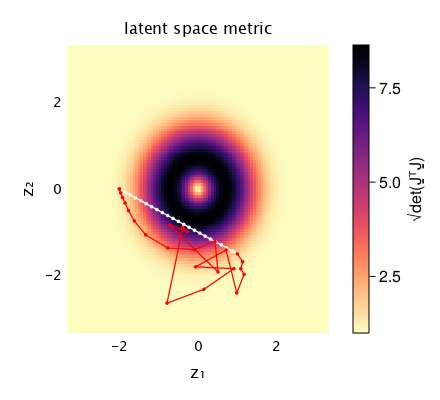

In [35]:
# Extract solutions into matrix
u = hcat(sol.u...)
# Split speed and coordinates
γ = u[1:param[:in_dim], :]
dγ = u[param[:in_dim]+1:end, :]

# Initialize figure
fig = Figure(resolution=(1.1 * 400, 400))

# Add GridLayout
gl = GridLayout(fig[1, 1])

# Add ax_inputis for latent space
ax_input = Axis(
    gl[1, 1],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space metric"
)

# Plot metric as a heatmap
hm = heatmap!(
    ax_input, z1, z2, manifold_metric, colormap=Reverse(:magma),
)

# # Plot geodesic
# lines!(ax_input, eachrow(γ)...)
# # Add initial and final points
# scatter!(ax_input, eachrow(γ[:, [1, end]])...)

# Add initial guess
scatterlines!(ax_input, eachrow(γ₀)..., markersize=5, color=:white)
# Add optimized curve
scatterlines!(ax_input, eachrow(γ_opt)..., markersize=5, color=:red)

# Add colorbar
Colorbar(fig[:, end+1], hm, label="√det(J̲̲ᵀJ̲̲)") 

fig

In [ ]:
function curve_gradient_descent!(
    γ::AbstractArray{<:AbstractFloat, 3}, 
    manifold::Function, 
    out_dim::Int;
    step_size=1E-3
)
    # Loop through steps
    for i = 2:size(γ, 3)
        # Update curve
        γ[:, :, i] .= γ[:, :, i-1] .- step_size .* 
                      ∇curve_energy(γ[:, :, i-1], manifold, out_dim)
    end # for
end # function

In [ ]:
# Define points to connect
# γ_init = [2.0, -2.0]
γ_init = [1.0, -1.5]
γ_end = [-2.0, 0.0]

# Define number of points
n_points = 25
# Define number of steps
n_steps = 1000

# Initialize curve
γ₀ = curve_init(γ_init, γ_end, n_points)
# Copy curve to optimize
γ_opt = Array{Float64}(undef, size(γ₀)..., n_steps)
# Substitute initial guess
γ_opt[:, :, 1] = γ₀

# Optimize curve
curve_gradient_descent!(γ_opt, f̲, 3)

In [ ]:
[curve_energy(γ, f̲) for γ in eachslice(γ_opt, dims=3)]